In [5]:
import os
from openai import OpenAI
from pydantic import BaseModel, Field, conlist
import time
import numpy as np
from numpy.linalg import norm
from scipy.interpolate import UnivariateSpline
from matplotlib import pyplot as plt
import re
from IPython.display import clear_output
import sys
import tiktoken

client = OpenAI(api_key = os.environ["OPENAI_API_KEY"])

class gen_format(BaseModel):
    Question: conlist(str, min_length=5, max_length=5) = Field(description="A list of five questions that could be answered by the given answer")
    
class rag_format(BaseModel):
    Ranked_Relevant_Information: list[str] = Field(description="The ranked list of information relevant to the query, with no paraphrasing or changing of the text from the files.")
    
def embedding_answers(answer, ideal) -> str:
    answer_resp = client.embeddings.create(
        input=answer,
        model="text-embedding-ada-002",
        encoding_format= "float",
    )
    ideal_resp = client.embeddings.create(
        input=ideal,
        model="text-embedding-ada-002",
        encoding_format= "float",
    )
    a=np.array(answer_resp.data[0].embedding)
    b=np.array(ideal_resp.data[0].embedding)
    result = np.dot(a,b)/(norm(a)*norm(b))
    return result

def embedding_questions(question, answer, question_model) -> str:
    og_question = client.embeddings.create(
        input=question,
        model="text-embedding-ada-002",
        encoding_format= "float",
    )
    gen_message="""
    You are a question generating agent. Your task is to generate a list of questions for the given answer.
    """
    gen_assistant = client.beta.assistants.create(
        name="gen_test",
        instructions=gen_message,
        model=question_model, 
        temperature = 0.0,
        top_p = 0.2,
        response_format= {
            "type": "json_schema",
            "json_schema": {
                "name": "answer",
                "schema": gen_format.model_json_schema()
            },
        }
    )
    
    thread = client.beta.threads.create(
                    messages=[],
                )
    
    parsed = client.beta.threads.messages.create(
                    thread_id=thread.id,
                    content=answer,
                    role='user',
                )
    
    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=gen_assistant.id,
        # pass the latest system message as instructions
        instructions=gen_message,
    )
    run = client.beta.threads.runs.retrieve(run.id, thread_id=thread.id)
    while run.status!="completed":
        run = client.beta.threads.runs.retrieve(run.id, thread_id=thread.id)
    response_messages = client.beta.threads.messages.list(thread.id, order="asc")
    for message in response_messages.data:
        for content in message.content:
            output=content.text.value
            if output.startswith("{"):
                data=json.loads(output)
                generated=data["Question"]
    client.beta.assistants.delete(assistant_id=gen_assistant.id)
    result=[]
    for gen_question in generated:
        gen_question_vector = client.embeddings.create(
            input=gen_question,
            model="text-embedding-ada-002",
            encoding_format= "float",
        )
        a=np.array(gen_question_vector.data[0].embedding)
        b=np.array(og_question.data[0].embedding)
        result.append(np.dot(a, b)/(norm(a)*norm(b)))
    return result
    
def embedding_search(vector_store, question, answer, search_model) -> str:
    rag_message="""You are a retrieval agent tasked with performing file searches to find information for the purpose of providing answers.
        Find pieces of information that will be directly relevant for answering the query and rank these pieces of information from most relevant to least relevant.
        You must quote the passages from the files directly. Do not paraphrase or change the text in any way.
        Do not add anything else to the passage quotations, including sources and filenames.
        If no information is relevant, you must return a single piece of information, where you state "No information found".
        Ideally, these pieces of information will be sentences, phrases, data points or sets of data points, but you have limited flexiblility to include other pieces of information if you think they are appropriate.
        
        You must use tool call (i.e., file search).
        
        You know about the content of the code-base.
        """
    rag_assistant = client.beta.assistants.create(
        name="rag_test",
        instructions=rag_message,
        tools=[
            {"type": "file_search",
                "file_search":{
                    'max_num_results': 10,
                    "ranking_options": {
                        "ranker": "auto",
                        "score_threshold": 0.6
                    }
                }
            }
        ],
        tool_resources={"file_search": {"vector_store_ids":[vector_store.id]}},
        model=search_model, 
        temperature = 0,
        top_p = 0.2,
        response_format= {
            "type": "json_schema",
            "json_schema": {
                "name": "answer",
                "schema": rag_format.model_json_schema()
            },
        }
    )
    thread = client.beta.threads.create(
                    messages=[],
                )
    
    parsed = client.beta.threads.messages.create(
                    thread_id=thread.id,
                    content=question,
                    role='user',
                )
    
    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=rag_assistant.id,
        # pass the latest system message as instructions
        instructions=rag_message,
    )
    run = client.beta.threads.runs.retrieve(run.id, thread_id=thread.id)
    while run.status!="completed":
        run = client.beta.threads.runs.retrieve(run.id, thread_id=thread.id)
    response_messages = client.beta.threads.messages.list(thread.id, order="asc")
    for message in response_messages.data:
        for content in message.content:
            output=content.text.value
            if output.startswith("{"):
                data=json.loads(output)
                try:
                    information=data["Ranked_Relevant_Information"]
                except:
                    information=data["Ranked Relevant Information"]
    if ("information" in locals()):
        #uncomment for hallucination guarding
        """run_steps = client.beta.threads.runs.steps.list(
            thread_id=thread.id,
            run_id=run.id
        )
        j=0
        for step in run_steps.data:
            #wait until the runs.steps.list has finished
            while step.status!="completed":
                run_steps = client.beta.threads.runs.steps.list(
                    thread_id=thread.id,
                    run_id=run.id
                )
            if (j!=0):
                retrieved_step = client.beta.threads.runs.steps.retrieve(
                    thread_id=step.thread_id,
                    run_id=run.id,
                    step_id=step.id,
                    include=["step_details.tool_calls[*].file_search.results[*].content"]
                )
                #check for hallucinations and flag all "offending text" from the passed information list
                information=hallucination_check(retrieved_step, information, question, 20)
            j+=1
        """
        pass
    else:
        information=["No information."]
    answer_resp = client.embeddings.create(
        input=answer,
        model="text-embedding-ada-002",
        encoding_format= "float",
    )
    results=[]
    for i in range(len(information)):
        info_resp = client.embeddings.create(
            input=information[i],
            model="text-embedding-ada-002",
            encoding_format= "float",
        )
        a=np.array(info_resp.data[0].embedding)
        b=np.array(answer_resp.data[0].embedding)
        results.append(np.dot(a, b)/(norm(a)*norm(b)))
    i=0
    #add is binary True/False
    add=1
    my_diff=0
    mean_score=[]
    for score in results:
        if (i!=0):
            my_diff=np.absolute(score-store)
            if (i==1):
                ref_diff=my_diff
            if (my_diff>=2*ref_diff):
                add=0
        if (add==1):
            mean_score.append(score)
            store=score
            i+=1
    return mean_score
def hallucination_check(retrieved_step, information, question, char_match):
    raw_information=""
    for result in retrieved_step.step_details.tool_calls[0].file_search.results:
        raw_information=raw_information+result.content[0].text
    #regex expression to remove all references from the text before "cleaning".
    raw_information = re.sub(r"\(\d+\)|\[\d+\]|\(.*Fig.*\)|\(.*Table.*\)", "", raw_information)
    file_information=''.join(ch for ch in raw_information if ch.isalnum())
    for i in range(len(information)):
        verify=information[i].split("...")
        for split in verify:
            filtered_information=''.join(ch for ch in split if ch.isalnum())
            if not (filtered_information in file_information):
                clear_output(wait=True)
                print("AI is answering this question:\n"+question)
                print("AI understood:\n"+split)
                length=len(filtered_information)
                if length < char_match:
                    char_match = length
                index=file_information.find(filtered_information[:char_match])
                if (index!=-1):
                    print("The file contained:\n"+file_information[index:index+length])
                else:
                    index=file_information.find(filtered_information[length-char_match:])
                    if (index!=-1):
                        print("The file contained:\n"+file_information[index-length+char_match:index+char_match])
                    else:
                        print("The file contained:\n"+raw_information)
                print("Waiting for user input...")
                print("Correct the potential hallucination. If the AI is correct, type 'y'. If information given by the AI is not in the file segment, type 'n'.", end='', flush=True)
                user=input()
                print("User entered:", user)
                if (user!='y'):
                    print("The file contained:\n"+raw_information)
                    print("Correct the potential hallucination. If the AI is correct, type 'y'. If no information from these chunks is relevant, type 'n'. Otherwise, input what the information should be.", end='', flush=True)
                    user=input()
                    if (user!='y'):
                        if(user=='n'):
                            split="Null information."
                        else:
                            split=user
        information[i]=""
        for split in verify:
            information[i]=information[i]+"..."+split
        information[i]=information[i][3:]
    return information

In [7]:
import pandas as pd

assistant_data = "/home/adrian/Documents/University Work/Part III Project/PaperQA2/LitQA2_Papers"
lit = pd.read_csv('../PaperQA2/LitQA2_edit.csv')
question=[]
for i in range(lit.shape[0]):
    question.append(lit.loc[i, "question"])
#extract answer from these agent and ideal from LitQA2
with open("output_4o_mini_exact_extended.txt", 'r', encoding='utf-8') as file:
    file_content = file.read()
spaces=0
tab=0
i=0
answer=[]
ideal=[]
for char in file_content:
    if (spaces==2 and char != "\t" and tab==0):
        answer[i]+=char
    elif (char =="\t"):
        spaces=0
        ideal.append("")
        tab+=1
    elif (char != "\n" and tab==1):
        ideal[i]+=char
    elif (char == "\n" and tab==1):
        i+=1
        tab=0
    if (char == " " and spaces<2 and tab==0):
        spaces+=1
        if (spaces==2):
            answer.append("")

Embedding Questions


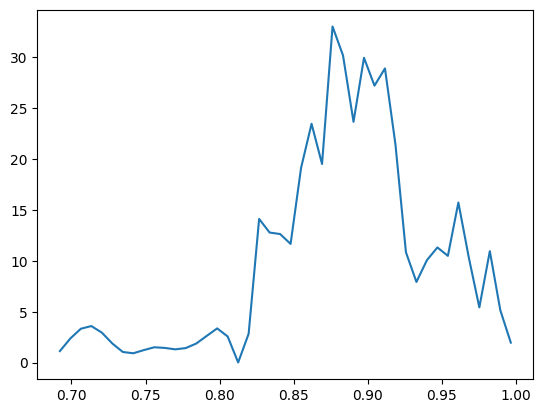

0.8861574824189592
Embedding Answers


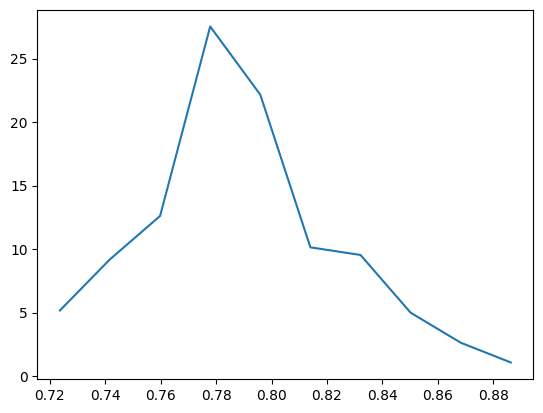

0.7880268203616886
Embedding Search


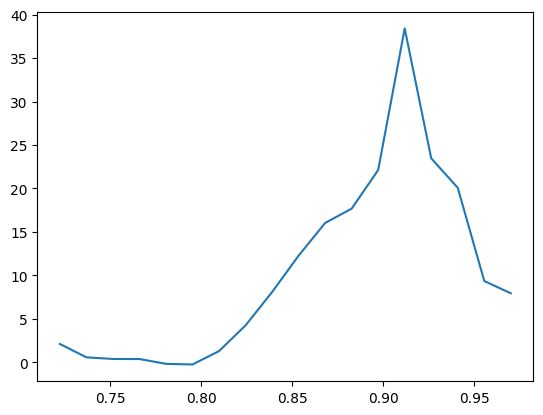

0.9004262204338533


In [5]:
#LitQA2, for output_4o_mini_exact.txt, not extended
answer_store=[]
gen=[]
print("Embedding Questions")
for i in range(len(answer)):
    answer[i]=" ".join(word for word in answer[i].split() if ".pdf" not in word)
    if not ("No information" in answer[i]):
        store=embedding_questions(question[i], answer[i], "gpt-4o-mini")
        for score in store:
            gen.append(score)
gen_score=np.sum(np.array(gen))/float(len(gen))
n = len(gen)//10
s=np.array(gen)
p, x = np.histogram(s, bins=n) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=n)
plt.plot(x, f(x))
plt.show()
print(gen_score)
print("Embedding Answers")
for i in range(len(answer)):
    answer_store.append(embedding_answers(answer[i], ideal[i]))
answer_score=np.sum(np.array(answer_store))/float(len(answer_store))
n = len(answer_store)//10
s=np.array(answer_store)
p, x = np.histogram(s, bins=n) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=n)
plt.plot(x, f(x))
plt.show()
print(answer_score)
print("Embedding Search")
vector_store=client.beta.vector_stores.retrieve(vector_store_id="vs_67ddfa2429148191b7b66e828f24c45c")
vector_store_id=vector_store.id
search=[]
for i in range(len(answer)):
    store=embedding_search(vector_store, question[i], answer[i], "gpt-4o-mini")
    for score in store:
        search.append(score)
search_score=np.sum(np.array(search))/float(len(search))
n = len(search)//10
s=np.array(search)
p, x = np.histogram(s, bins=n) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=n)
plt.plot(x, f(x))
plt.show()
print(search_score)

Embedding Questions


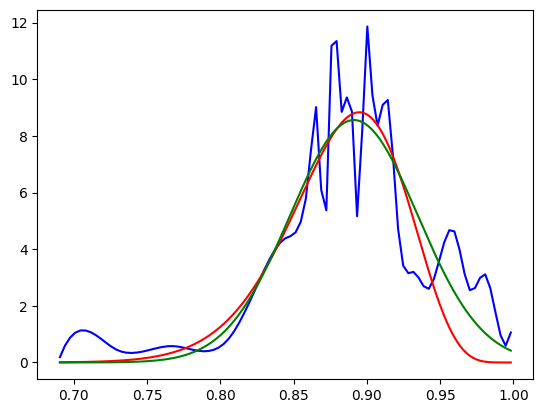

Beta log-likelihood: -522.6028295055737
Normal log-likelihood: -511.3139369626018
Normal distribution mean: 0.8911528080303984+/-0.04359169358365192
Beta distribution mean: 0.8819996405669369+/-0.04072170231411109
Embedding Answers


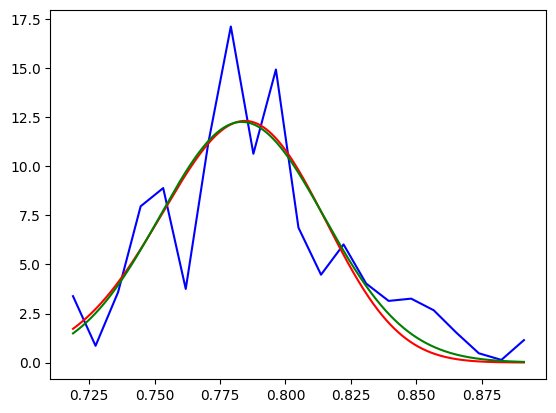

Beta log-likelihood: 712.7119305867301
Normal log-likelihood: 1011.4752124890829
Normal distribution mean: 0.7833383073025644+/-0.03137948517744115
Beta distribution mean: 0.7812976874587241+/-0.030984115963446853
Embedding Search


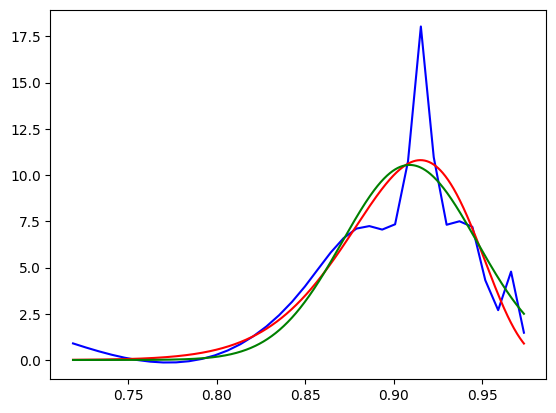

Beta log-likelihood: 168.6784603602522
Normal log-likelihood: -879.4831553085878
Normal distribution mean: 0.9090443402686861+/-0.038048177883736774
Beta distribution mean: 0.901510187727446+/-0.03789722604143624


In [7]:
#LitQA2, for output_4o_mini_exact.txt, not extended
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as optimize

def scaled_normal(x, scale, mu, sigma):
    return scale * stats.norm.pdf(x, loc=mu, scale=sigma)
def scaled_beta(x, a, b, scale):
    return scale*stats.beta.pdf(x, a, b, scale=1.0)
    
n = len(gen)//5
s=np.array(gen)
p, x = np.histogram(s, bins=n, density=True) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=n)
popt, pcov_beta = optimize.curve_fit(scaled_beta, x, f(x), p0=[2.0, 2.0, 1.0])
a, b, scale_beta = popt
popt, pcov_norm = optimize.curve_fit(scaled_normal, x, f(x), p0=[1.0, 0.7, 0.1])
scale_norm, mu, sigma = popt
print("Embedding Questions")
x_plot=np.linspace(np.amin(x), np.amax(x), 1000)
plt.plot(x, f(x), "b-")
plt.plot(x_plot, scaled_beta(x_plot, a, b, scale_beta), "r-")
plt.plot(x_plot, scaled_normal(x_plot, scale_norm, mu, sigma), "g-")
plt.show()
filtered_beta=np.where(scaled_beta(x_plot, a, b, scale_beta)>0.00001, scaled_beta(x_plot, a, b, scale_beta), 0.00001)
filtered_norm=np.where(scaled_normal(x_plot, scale_norm, mu, sigma)>0.00001, scaled_normal(x_plot, scale_norm, mu, sigma), 0.00001)
print("Beta log-likelihood: "+str(np.sum(np.log(filtered_beta))))
print("Normal log-likelihood: "+str(np.sum(np.log((filtered_norm)))))
print("Normal distribution mean: "+str(mu)+"+/-"+str(sigma))
print("Beta distribution mean: "+str(stats.beta.mean(a, b, scale=1.0))+"+/-"+str(stats.beta.std(a, b, scale=1.0)))

n = len(answer_store)//5
s=np.array(answer_store)
p, x = np.histogram(s, bins=n, density=True) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=n)
popt, pcov_beta = optimize.curve_fit(scaled_beta, x, f(x), p0=[2.0, 2.0, 1.0])
a, b, scale_beta = popt
popt, pcov_norm = optimize.curve_fit(scaled_normal, x, f(x), p0=[1.0, 0.7, 0.1])
scale_norm, mu, sigma = popt
print("Embedding Answers")
x_plot=np.linspace(np.amin(x), np.amax(x), 1000)
plt.plot(x, f(x), "b-")
plt.plot(x_plot, scaled_beta(x_plot, a, b, scale_beta), "r-")
plt.plot(x_plot, scaled_normal(x_plot, scale_norm, mu, sigma), "g-")
plt.show()
filtered_beta=np.where(scaled_beta(x_plot, a, b, scale_beta)>0.00001, scaled_beta(x_plot, a, b, scale_beta), 0.00001)
filtered_norm=np.where(scaled_normal(x_plot, scale_norm, mu, sigma)>0.00001, scaled_normal(x_plot, scale_norm, mu, sigma), 0.00001)
print("Beta log-likelihood: "+str(np.sum(np.log(filtered_beta))))
print("Normal log-likelihood: "+str(np.sum(np.log((filtered_norm)))))
print("Normal distribution mean: "+str(mu)+"+/-"+str(sigma))
print("Beta distribution mean: "+str(stats.beta.mean(a, b, scale=1.0))+"+/-"+str(stats.beta.std(a, b, scale=1.0)))

n = len(search)//5
s=np.array(search)
p, x = np.histogram(s, bins=n, density=True) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=n)
popt, pcov_beta = optimize.curve_fit(scaled_beta, x, f(x), p0=[2.0, 2.0, 1.0])
a, b, scale_beta = popt
popt, pcov_norm = optimize.curve_fit(scaled_normal, x, f(x), p0=[1.0, 0.7, 0.1])
scale_norm, mu, sigma = popt
print("Embedding Search")
x_plot=np.linspace(np.amin(x), np.amax(x), 1000)
plt.plot(x, f(x), "b-")
plt.plot(x_plot, scaled_beta(x_plot, a, b, scale_beta), "r-")
plt.plot(x_plot, scaled_normal(x_plot, scale_norm, mu, sigma), "g-")
plt.show()
filtered_beta=np.where(scaled_beta(x_plot, a, b, scale_beta)>0.00001, scaled_beta(x_plot, a, b, scale_beta), 0.00001)
filtered_norm=np.where(scaled_normal(x_plot, scale_norm, mu, sigma)>0.00001, scaled_normal(x_plot, scale_norm, mu, sigma), 0.00001)
print("Beta log-likelihood: "+str(np.sum(np.log(filtered_beta))))
print("Normal log-likelihood: "+str(np.sum(np.log((filtered_norm)))))
print("Normal distribution mean: "+str(mu)+"+/-"+str(sigma))
print("Beta distribution mean: "+str(stats.beta.mean(a, b, scale=1.0))+"+/-"+str(stats.beta.std(a, b, scale=1.0)))

Embedding Questions
99.047619047619054

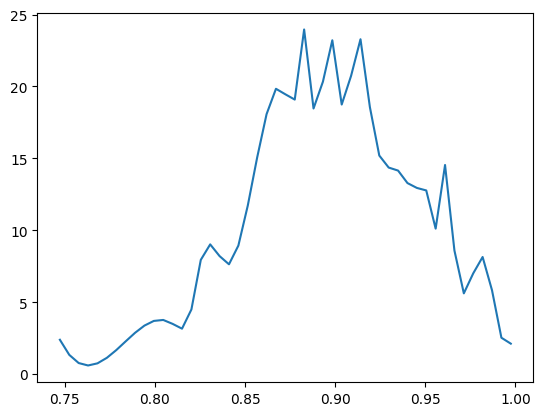

0.895403001416704
Embedding Answers
99.047619047619054

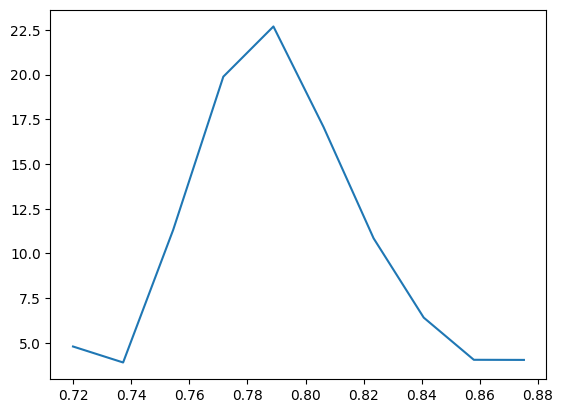

0.7927817265796527
Embedding Search
99.047619047619054

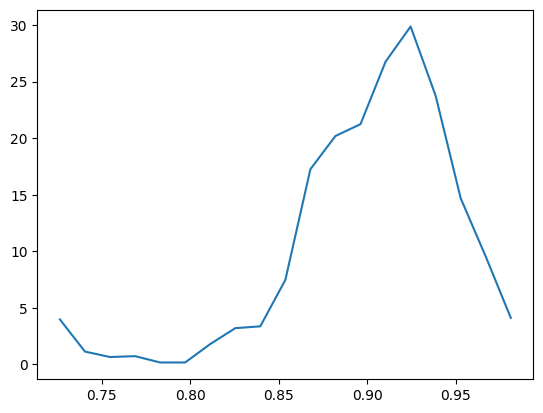

0.9033024990288758


In [51]:
#LitQA2 extended
answer_store=[]
gen=[]
print("Embedding Questions")
for i in range(len(answer)):
    print(i/len(answer)*100, end="")
    print("\r", end="")
    answer[i]=" ".join(word for word in answer[i].split() if ".pdf" not in word)
    if not ("No information" in answer[i]):
        store=embedding_questions(question[i], answer[i], "gpt-4o-mini")
        for score in store:
            gen.append(score)
gen_score=np.sum(np.array(gen))/float(len(gen))
n = len(gen)//10
s=np.array(gen)
p, x = np.histogram(s, bins=n) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=n)
plt.plot(x, f(x))
plt.show()
print(gen_score)
print("Embedding Answers")
for i in range(len(answer)):
    print(i/len(answer)*100, end="")
    print("\r", end="")
    answer_store.append(embedding_answers(answer[i], ideal[i]))
answer_score=np.sum(np.array(answer_store))/float(len(answer_store))
n = len(answer_store)//10
s=np.array(answer_store)
p, x = np.histogram(s, bins=n) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=n)
plt.plot(x, f(x))
plt.show()
print(answer_score)
print("Embedding Search")
vector_store=client.beta.vector_stores.retrieve(vector_store_id="vs_67ddfa2429148191b7b66e828f24c45c")
vector_store_id=vector_store.id
search=[]
for i in range(len(answer)):
    print(i/len(answer)*100, end="")
    print("\r", end="")
    store=embedding_search(vector_store, question[i], answer[i], "gpt-4o-mini")
    for score in store:
        search.append(score)
search_score=np.sum(np.array(search))/float(len(search))
n = len(search)//10
s=np.array(search)
p, x = np.histogram(s, bins=n) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=n)
plt.plot(x, f(x))
plt.show()
print(search_score)

Embedding Questions


/tmp/ipykernel_6174/869454342.py:75: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov_norm = optimize.curve_fit(scaled_2normal, x, func(x), p0=[0.5, 0.5, 0.7, 0.7, 0.1, 0.1])


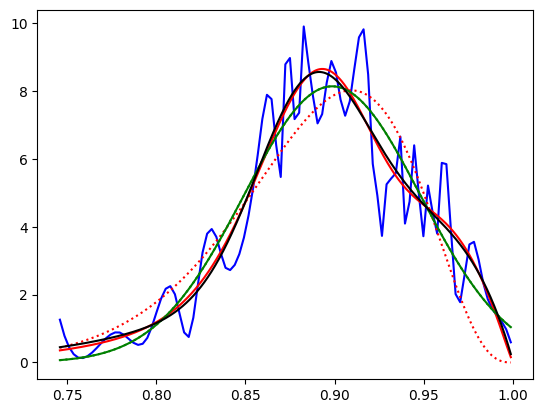

(0.9797829866143561, 2.7552454475893246e-09)
(0.9851578930083257, 6.688853425032989e-09)
(0.9971836403970106, 3.105365706483289e-09)
(0.9851587743641612, 6.688436237718897e-09)
(0.9989539775496742, 2.773737736574902e-10)
Beta log-likelihood: 83.12889444617839
Normal log-likelihood: 84.83285673751062
2Beta log-likelihood: -131.49748600253284
2Normal log-likelihood: -1054.9464312232867
Combined log-likelihood: -67.62973140214244
Normal distribution mean: 0.8985783583238445+/-0.049381760047517126
Beta distribution mean: 0.886333347937721+/-0.05241701931875667
Normal distribution mean1: 0.8985784160338911+/-0.049381879328189486 Normal distribution mean2: -2.0398469764482856+/-0.08513371277805679
Beta distribution mean1: 0.8993123214747174+/-0.06337900190199192 Beta distribution mean2: 0.8809949921243743+/-0.029815594112999486
Combined distribution normal mean: 0.886595879106214+/-0.03063681325478912 Combined distribution beta mean: 0.8936351696654367+/-0.069578323649163
Embedding Answers


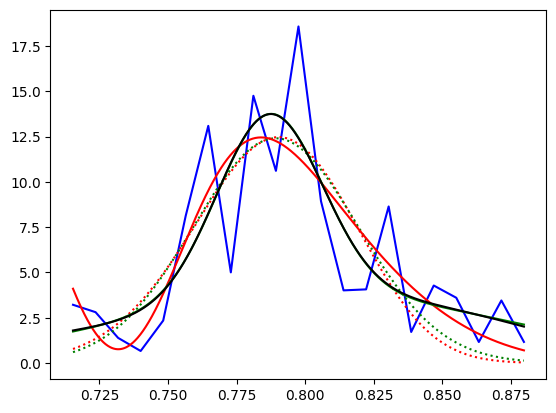

(0.9120988467313474, 1.0862561718327279e-08)
(0.9266995830372055, 1.028843213884278e-14)
(0.9610983260077048, 1.0670334922710176e-14)
(0.9837935120139163, 2.1739597210086725e-11)
(0.984310587120509, 2.066349196784556e-11)
Beta log-likelihood: 21.4317382931176
Normal log-likelihood: 24.856449040571423
2Beta log-likelihood: -196.55730475173576
2Normal log-likelihood: -3.696269777491282
Combined log-likelihood: -3.0311096524730425
Normal distribution mean: 0.7893217523799682+/-0.030035121824982646
Beta distribution mean: 0.7872893964503044+/-0.02950305060390226
Normal distribution mean1: 0.7871991469432575+/-0.019002581939088097 Normal distribution mean2: 0.8038665154143276+/-0.07108299230869862
Beta distribution mean1: 0.7273289892274861+/-0.02768167271478525 Beta distribution mean2: 0.7014237222780397+/-0.07352887622965391
Combined distribution normal mean: 0.7869987067850825+/-0.019113501114364332 Combined distribution beta mean: 0.790894784238064+/-0.07039615568924837
Embedding Search

/tmp/ipykernel_6174/869454342.py:85: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov_norm = optimize.curve_fit(scaled_norm_beta, x, func(x), p0=[0.5, 0.7, 0.1, 2.0, 2.0, 0.5])


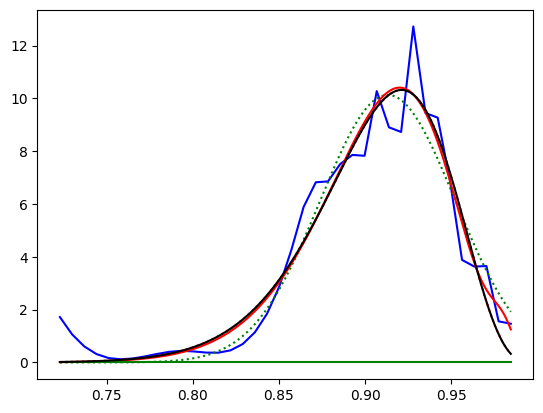

(0.9752038584567659, 9.71704669992506e-09)
(0.9608827911387557, 8.211691604340576e-14)
(0.9793592237453612, 8.886547460691522e-11)
(2.5908787360362145e-06, 2.8764532267591284e-20)
(0.9752034648757654, 9.714057048763859e-09)
Beta log-likelihood: 8.893809373045817
Normal log-likelihood: -29.002104615659007
2Beta log-likelihood: -355.4564341166406
2Normal log-likelihood: -376.37416186914066
Combined log-likelihood: -428.59746041632434
Normal distribution mean: 0.9132133983692056+/-0.039159975478771474
Beta distribution mean: 0.9053653195572459+/-0.03980492295469883
Normal distribution mean1: 0.5+/-0.1 Normal distribution mean2: 0.5+/-0.1
Beta distribution mean1: 0.9052316369818126+/-0.038562507553909206 Beta distribution mean2: 0.9765161734146526+/-0.008378050707143071
Combined distribution normal mean: 3.223976989989152+/-0.24327502162500125 Combined distribution beta mean: 0.905365344208496+/-0.0398048871802129


In [52]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as optimize
import scipy.integrate as integrate

def scaled_normal(x, scale, mu, sigma):
    return scale * stats.norm.pdf(x, loc=mu, scale=sigma)
def scaled_beta(x, a, b, scale):
    return scale*stats.beta.pdf(x, a, b, scale=1.0)
def scaled_2normal(x, scale1, scale2, mu1, mu2, sigma1, sigma2):
    return scale1 * stats.norm.pdf(x, loc=mu1, scale=sigma1)+scale2 * stats.norm.pdf(x, loc=mu2, scale=sigma2)
def scaled_2beta(x, a, b, c, d, scale1, scale2):
    return scale1*stats.beta.pdf(x, a, b, scale=1.0)+scale2*stats.beta.pdf(x, c, d, scale=1.0)
def scaled_norm_beta(x, scale_norm, mu, sigma, a, b, scale_beta):
    return scale_norm * stats.norm.pdf(x, loc=mu, scale=sigma)+scale_beta*stats.beta.pdf(x, a, b, scale=1.0)
    
def scaled_normal_log(x, scale, mu, sigma):
    filtered_norm=np.where(scaled_normal(x, scale, mu, sigma)>0.00001, scaled_normal(x, scale, mu, sigma), 0.00001)
    return np.sum(np.log(filtered_norm))
def scaled_beta_log(x, a, b, scale):
    filtered_beta=np.where(scaled_beta(x, a, b, scale)>0.00001, scaled_beta(x, a, b, scale), 0.00001)
    return np.sum(np.log(filtered_beta))
def scaled_2normal_log(x, scale1, scale2, mu1, mu2, sigma1, sigma2):
    store1=scale1 * stats.norm.pdf(x, loc=mu1, scale=sigma1)
    store2=scale2 * stats.norm.pdf(x, loc=mu2, scale=sigma2)
    store1=np.where(store1>0.00001, store1, 0.00001)
    store2=np.where(store2>0.00001, store2, 0.00001)
    store=np.log(store1)+np.log(store2)
    return np.sum(store)
def scaled_2beta_log(x, a, b, c, d, scale1, scale2):
    store1=scale1*stats.beta.pdf(x, a, b, scale=1.0)
    store2=scale2*stats.beta.pdf(x, c, d, scale=1.0)
    store1=np.where(store1>0.00001, store1, 0.00001)
    store2=np.where(store2>0.00001, store2, 0.00001)
    store=np.log(store1)+np.log(store2)
    return np.sum(store)
def scaled_norm_beta_log(x, scale_norm, mu, sigma, a, b, scale_beta):
    store1=scale_norm * stats.norm.pdf(x, loc=mu, scale=sigma)
    store2=scale_beta*stats.beta.pdf(x, a, b, scale=1.0)
    store1=np.where(store1>0.00001, store1, 0.00001)
    store2=np.where(store2>0.00001, store2, 0.00001)
    store=np.log(store1)+np.log(store2)
    return np.sum(store)

def stats_print_graphs(n, s):
    p, x = np.histogram(s, bins=n, density=True) # bin it into n = N//10 bins
    x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
    func = UnivariateSpline(x, p, s=n)
    try:
        popt, pcov_beta = optimize.curve_fit(scaled_beta, x, func(x), p0=[2.0, 2.0, 1.0])
        alpha, beta, scale_beta = popt
    except:
        alpha=1.0
        beta=1.0
        scale_beta=0.0001
    try:
        popt, pcov_norm = optimize.curve_fit(scaled_normal, x, func(x), p0=[1.0, 0.7, 0.1])
        scale_norm, mu, sigma = popt
    except:
        scale_norm=0.0001
        mu=0.5
        sigma=0.1
    try:
        popt, pcov_beta = optimize.curve_fit(scaled_2beta, x, func(x), p0=[2.0, 2.0, 2.0, 2.0, 0.5, 0.5])
        a, b, c, d, scale_beta1, scale_beta2 = popt
    except:
        a=1.0
        b=1.0
        c=1.0
        d=1.0
        scale_beta1=0.0001
        scale_beta2=0.0001
    try:
        popt, pcov_norm = optimize.curve_fit(scaled_2normal, x, func(x), p0=[0.5, 0.5, 0.7, 0.7, 0.1, 0.1])
        scale_norm1, scale_norm2, mu1, mu2, sigma1, sigma2 = popt
    except:
        scale_norm1=0.0001
        scale_norm2=0.0001
        mu1=0.5
        mu2=0.5
        sigma1=0.1
        sigma2=0.1
    try:
        popt, pcov_norm = optimize.curve_fit(scaled_norm_beta, x, func(x), p0=[0.5, 0.7, 0.1, 2.0, 2.0, 0.5])
        scale_norm3, mu3, sigma3, e, f, scale_beta3 = popt
    except:
        scale_norm3=0.0001
        mu3=0.5
        sigma3=0.1
        e=1.0
        f=1.0
        scale_beta3=0.0001
    min_x=np.amin(x)
    max_x=np.amax(x)
    x_plot=np.linspace(np.amin(x), np.amax(x), 1000)
    plt.plot(x, func(x), "b-")
    plt.plot(x_plot, scaled_beta(x_plot, alpha, beta, scale_beta), "r:")
    plt.plot(x_plot, scaled_normal(x_plot, scale_norm, mu, sigma), "g:")
    plt.plot(x_plot, scaled_2beta(x_plot, a, b, c, d, scale_beta1, scale_beta2), "r-")
    plt.plot(x_plot, scaled_2normal(x_plot, scale_norm1, scale_norm2, mu1, mu2, sigma1, sigma2), "g-")
    plt.plot(x_plot, scaled_norm_beta(x_plot, scale_norm3, mu3, sigma3, e, f, scale_beta3), "k-")
    plt.show()
    beta_normalisation=integrate.quad(lambda x: scaled_beta(x, alpha, beta, scale_beta), min_x, max_x)
    print(beta_normalisation)
    norm_normalisation=integrate.quad(lambda x: scaled_normal(x, scale_norm, mu, sigma), min_x, max_x)
    print(norm_normalisation)
    beta2_normalisation=integrate.quad(lambda x: scaled_2beta(x, a, b, c, d, scale_beta1, scale_beta2), min_x, max_x)
    print(beta2_normalisation)
    norm2_normalisation=integrate.quad(lambda x: scaled_2normal(x, scale_norm1, scale_norm2, mu1, mu2, sigma1, sigma2), min_x, max_x)
    print(norm2_normalisation)
    norm_beta_normalisation=integrate.quad(lambda x: scaled_norm_beta(x, scale_norm3, mu3, sigma3, e, f, scale_beta3), min_x, max_x)
    print(norm_beta_normalisation)
    print("Beta log-likelihood: "+str(scaled_beta_log(x, alpha, beta, scale_beta)-n*np.log(beta_normalisation[0])))
    print("Normal log-likelihood: "+str(scaled_normal_log(x, scale_norm, mu, sigma)-n*np.log(norm_normalisation[0])))
    print("2Beta log-likelihood: "+str(scaled_2beta_log(x, a, b, c, d, scale_beta1, scale_beta2)-n*np.log(beta2_normalisation[0])))
    print("2Normal log-likelihood: "+str(scaled_2normal_log(x, scale_norm1, scale_norm2, mu1, mu2, sigma1, sigma2)-n*np.log(norm2_normalisation[0])))
    print("Combined log-likelihood: "+str(scaled_norm_beta_log(x, scale_norm3, mu3, sigma3, e, f, scale_beta3)-n*np.log(norm_beta_normalisation[0])))
    print("Normal distribution mean: "+str(mu)+"+/-"+str(sigma))
    print("Beta distribution mean: "+str(stats.beta.mean(alpha, beta, scale=1.0))+"+/-"+str(stats.beta.std(alpha, beta, scale=1.0)))
    print("Normal distribution mean1: "+str(mu1)+"+/-"+str(sigma1)+" Normal distribution mean2: "+str(mu2)+"+/-"+str(sigma2))
    print("Beta distribution mean1: "+str(stats.beta.mean(a, b, scale=1.0))+"+/-"+str(stats.beta.std(a, b, scale=1.0))+" Beta distribution mean2: "+str(stats.beta.mean(c, d, scale=1.0))+"+/-"+str(stats.beta.std(c, d, scale=1.0)))
    print("Combined distribution normal mean: "+str(mu3)+"+/-"+str(sigma3)+" Combined distribution beta mean: "+str(stats.beta.mean(e, f, scale=1.0))+"+/-"+str(stats.beta.std(e, f, scale=1.0)))

n = len(gen)//5
s=np.array(gen)
print("Embedding Questions")
stats_print_graphs(n, s)

n = len(answer_store)//5
s=np.array(answer_store)
print("Embedding Answers")
stats_print_graphs(n, s)

n = len(search)//5
s=np.array(search)
print("Embedding Search")
stats_print_graphs(n, s)

In [39]:
import re

def split_into_sentences(text):
    # Regular expression to split sentences while keeping abbreviations intact
    sentence_endings = r'(?<!\w\.\w)(?<![A-Z][a-z]\.)(?<=\.|\?|!)\s'
    sentences = re.split(sentence_endings, text)
    return [s.strip() for s in sentences if s.strip()]

# Example usage
text = """
Alice was beginning to get very tired of sitting by her sister on the
bank, and of having nothing to do: once or twice she had peeped into
the book her sister was reading, but it had no pictures or
conversations in it, “and what is the use of a book,” thought Alice
“without pictures or conversations?”

So she was considering in her own mind (as well as she could, for the
hot day made her feel very sleepy and stupid), whether the pleasure of
making a daisy-chain would be worth the trouble of getting up and
picking the daisies, when suddenly a White Rabbit with pink eyes ran
close by her.

There was nothing so _very_ remarkable in that; nor did Alice think it
so _very_ much out of the way to hear the Rabbit say to itself, “Oh
dear! Oh dear! I shall be late!” (when she thought it over afterwards,
it occurred to her that she ought to have wondered at this, but at the
time it all seemed quite natural); but when the Rabbit actually _took a
watch out of its waistcoat-pocket_, and looked at it, and then hurried
on, Alice started to her feet, for it flashed across her mind that she
had never before seen a rabbit with either a waistcoat-pocket, or a
watch to take out of it, and burning with curiosity, she ran across the
field after it, and fortunately was just in time to see it pop down a
large rabbit-hole under the hedge.

In another moment down went Alice after it, never once considering how
in the world she was to get out again.

The rabbit-hole went straight on like a tunnel for some way, and then
dipped suddenly down, so suddenly that Alice had not a moment to think
about stopping herself before she found herself falling down a very
deep well.

Either the well was very deep, or she fell very slowly, for she had
plenty of time as she went down to look about her and to wonder what
was going to happen next. First, she tried to look down and make out
what she was coming to, but it was too dark to see anything; then she
looked at the sides of the well, and noticed that they were filled with
cupboards and book-shelves; here and there she saw maps and pictures
hung upon pegs. She took down a jar from one of the shelves as she
passed; it was labelled “ORANGE MARMALADE”, but to her great
disappointment it was empty: she did not like to drop the jar for fear
of killing somebody underneath, so managed to put it into one of the
cupboards as she fell past it.

“Well!” thought Alice to herself, “after such a fall as this, I shall
think nothing of tumbling down stairs! How brave they’ll all think me
at home! Why, I wouldn’t say anything about it, even if I fell off the
top of the house!” (Which was very likely true.)

Down, down, down. Would the fall _never_ come to an end? “I wonder how
many miles I’ve fallen by this time?” she said aloud. “I must be
getting somewhere near the centre of the earth. Let me see: that would
be four thousand miles down, I think—” (for, you see, Alice had learnt
several things of this sort in her lessons in the schoolroom, and
though this was not a _very_ good opportunity for showing off her
knowledge, as there was no one to listen to her, still it was good
practice to say it over) “—yes, that’s about the right distance—but
then I wonder what Latitude or Longitude I’ve got to?” (Alice had no
idea what Latitude was, or Longitude either, but thought they were nice
grand words to say.)

Presently she began again. “I wonder if I shall fall right _through_
the earth! How funny it’ll seem to come out among the people that walk
with their heads downward! The Antipathies, I think—” (she was rather
glad there _was_ no one listening, this time, as it didn’t sound at all
the right word) “—but I shall have to ask them what the name of the
country is, you know. Please, Ma’am, is this New Zealand or Australia?”
(and she tried to curtsey as she spoke—fancy _curtseying_ as you’re
falling through the air! Do you think you could manage it?) “And what
an ignorant little girl she’ll think me for asking! No, it’ll never do
to ask: perhaps I shall see it written up somewhere.”

Down, down, down. There was nothing else to do, so Alice soon began
talking again. “Dinah’ll miss me very much to-night, I should think!”
(Dinah was the cat.) “I hope they’ll remember her saucer of milk at
tea-time. Dinah my dear! I wish you were down here with me! There are
no mice in the air, I’m afraid, but you might catch a bat, and that’s
very like a mouse, you know. But do cats eat bats, I wonder?” And here
Alice began to get rather sleepy, and went on saying to herself, in a
dreamy sort of way, “Do cats eat bats? Do cats eat bats?” and
sometimes, “Do bats eat cats?” for, you see, as she couldn’t answer
either question, it didn’t much matter which way she put it. She felt
that she was dozing off, and had just begun to dream that she was
walking hand in hand with Dinah, and saying to her very earnestly,
“Now, Dinah, tell me the truth: did you ever eat a bat?” when suddenly,
thump! thump! down she came upon a heap of sticks and dry leaves, and
the fall was over.

Alice was not a bit hurt, and she jumped up on to her feet in a moment:
she looked up, but it was all dark overhead; before her was another
long passage, and the White Rabbit was still in sight, hurrying down
it. There was not a moment to be lost: away went Alice like the wind,
and was just in time to hear it say, as it turned a corner, “Oh my ears
and whiskers, how late it’s getting!” She was close behind it when she
turned the corner, but the Rabbit was no longer to be seen: she found
herself in a long, low hall, which was lit up by a row of lamps hanging
from the roof.

There were doors all round the hall, but they were all locked; and when
Alice had been all the way down one side and up the other, trying every
door, she walked sadly down the middle, wondering how she was ever to
get out again.

Suddenly she came upon a little three-legged table, all made of solid
glass; there was nothing on it except a tiny golden key, and Alice’s
first thought was that it might belong to one of the doors of the hall;
but, alas! either the locks were too large, or the key was too small,
but at any rate it would not open any of them. However, on the second
time round, she came upon a low curtain she had not noticed before, and
behind it was a little door about fifteen inches high: she tried the
little golden key in the lock, and to her great delight it fitted!

Alice opened the door and found that it led into a small passage, not
much larger than a rat-hole: she knelt down and looked along the
passage into the loveliest garden you ever saw. How she longed to get
out of that dark hall, and wander about among those beds of bright
flowers and those cool fountains, but she could not even get her head
through the doorway; “and even if my head would go through,” thought
poor Alice, “it would be of very little use without my shoulders. Oh,
how I wish I could shut up like a telescope! I think I could, if I only
knew how to begin.” For, you see, so many out-of-the-way things had
happened lately, that Alice had begun to think that very few things
indeed were really impossible.

There seemed to be no use in waiting by the little door, so she went
back to the table, half hoping she might find another key on it, or at
any rate a book of rules for shutting people up like telescopes: this
time she found a little bottle on it, (“which certainly was not here
before,” said Alice,) and round the neck of the bottle was a paper
label, with the words “DRINK ME,” beautifully printed on it in large
letters.

It was all very well to say “Drink me,” but the wise little Alice was
not going to do _that_ in a hurry. “No, I’ll look first,” she said,
“and see whether it’s marked ‘_poison_’ or not”; for she had read
several nice little histories about children who had got burnt, and
eaten up by wild beasts and other unpleasant things, all because they
_would_ not remember the simple rules their friends had taught them:
such as, that a red-hot poker will burn you if you hold it too long;
and that if you cut your finger _very_ deeply with a knife, it usually
bleeds; and she had never forgotten that, if you drink much from a
bottle marked “poison,” it is almost certain to disagree with you,
sooner or later.

However, this bottle was _not_ marked “poison,” so Alice ventured to
taste it, and finding it very nice, (it had, in fact, a sort of mixed
flavour of cherry-tart, custard, pine-apple, roast turkey, toffee, and
hot buttered toast,) she very soon finished it off.
“What a curious feeling!” said Alice; “I must be shutting up like a
telescope.”

And so it was indeed: she was now only ten inches high, and her face
brightened up at the thought that she was now the right size for going
through the little door into that lovely garden. First, however, she
waited for a few minutes to see if she was going to shrink any further:n = len(answer_store_control)//10
s=np.array(answer_store_control)
p, x = np.histogram(s, bins=n) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=n)
plt.plot(x, f(x))
plt.show()
print(answer_score)
she felt a little nervous about this; “for it might end, you know,”
said Alice to herself, “in my going out altogether, like a candle. I
wonder what I should be like then?” And she tried to fancy what the
flame of a candle is like after the candle is blown out, for she could
not remember ever having seen such a thing.

After a while, finding that nothing more happened, she decided on going
into the garden at once; but, alas for poor Alice! when she got to the
door, she found she had forgotten the little golden key, and when she
went back to the table for it, she found she could not possibly reach
it: she could see it quite plainly through the glass, and she tried her
best to climb up one of the legs of the table, but it was too slippery;
and when she had tired herself out with trying, the poor little thing
sat down and cried.

“Come, there’s no use in crying like that!” said Alice to herself,
rather sharply; “I advise you to leave off this minute!” She generally
gave herself very good advice, (though she very seldom followed it),
and sometimes she scolded herself so severely as to bring tears into
her eyes; and once she remembered trying to box her own ears for having
cheated herself in a game of croquet she was playing against herself,
for this curious child was very fond of pretending to be two people.
“But it’s no use now,” thought poor Alice, “to pretend to be two
people! Why, there’s hardly enough of me left to make _one_ respectable
person!”

Soon her eye fell on a little glass box that was lying under the table:
she opened it, and found in it a very small cake, on which the words
“EAT ME” were beautifully marked in currants. “Well, I’ll eat it,” said
Alice, “and if it makes me grow larger, I can reach the key; and if it
makes me grow smaller, I can creep under the door; so either way I’ll
get into the garden, and I don’t care which happens!”

She ate a little bit, and said anxiously to herself, “Which way? Which
way?”, holding her hand on the top of her head to feel which way it was
growing, and she was quite surprised to find that she remained the same
size: to be sure, this generally happens when one eats cake, but Alice
had got so much into the way of expecting nothing but out-of-the-way
things to happen, that it seemed quite dull and stupid for life to go
on in the common way.

So she set to work, and very soon finished off the cake.
“Curiouser and curiouser!” cried Alice (she was so much surprised, that
for the moment she quite forgot how to speak good English); “now I’m
opening out like the largest telescope that ever was! Good-bye, feet!”
(for when she looked down at her feet, they seemed to be almost out of
sight, they were getting so far off). “Oh, my poor little feet, I
wonder who will put on your shoes and stockings for you now, dears? I’m
sure _I_ shan’t be able! I shall be a great deal too far off to trouble
myself about you: you must manage the best way you can;—but I must be
kind to them,” thought Alice, “or perhaps they won’t walk the way I
want to go! Let me see: I’ll give them a new pair of boots every
Christmas.”

And she went on planning to herself how she would manage it. “They must
go by the carrier,” she thought; “and how funny it’ll seem, sending
presents to one’s own feet! And how odd the directions will look!

     _Alice’s Right Foot, Esq., Hearthrug, near the Fender,_ (_with
     Alice’s love_).

Oh dear, what nonsense I’m talking!”

Just then her head struck against the roof of the hall: in fact she was
now more than nine feet high, and she at once took up the little golden
key and hurried off to the garden door.

Poor Alice! It was as much as she could do, lying down on one side, to
look through into the garden with one eye; but to get through was more
hopeless than ever: she sat down and began to cry again.

“You ought to be ashamed of yourself,” said Alice, “a great girl like
you,” (she might well say this), “to go on crying in this way! Stop
this moment, I tell you!” But she went on all the same, shedding
gallons of tears, until there was a large pool all round her, about
four inches deep and reaching half down the hall.

After a time she heard a little pattering of feet in the distance, and
she hastily dried her eyes to see what was coming. It was the White
Rabbit returning, splendidly dressed, with a pair of white kid gloves
in one hand and a large fan in the other: he came trotting along in a
great hurry, muttering to himself as he came, “Oh! the Duchess, the
Duchess! Oh! won’t she be savage if I’ve kept her waiting!” Alice felt
so desperate that she was ready to ask help of any one; so, when the
Rabbit came near her, she began, in a low, timid voice, “If you please,
sir—” The Rabbit started violently, dropped the white kid gloves and
the fan, and skurried away into the darkness as hard as he could go.

Alice took up the fan and gloves, and, as the hall was very hot, she
kept fanning herself all the time she went on talking: “Dear, dear! How
queer everything is to-day! And yesterday things went on just as usual.
I wonder if I’ve been changed in the night? Let me think: was I the
same when I got up this morning? I almost think I can remember feeling
a little different. But if I’m not the same, the next question is, Who
in the world am I? Ah, _that’s_ the great puzzle!” And she began
thinking over all the children she knew that were of the same age as
herself, to see if she could have been changed for any of them.

“I’m sure I’m not Ada,” she said, “for her hair goes in such long
ringlets, and mine doesn’t go in ringlets at all; and I’m sure I can’t
be Mabel, for I know all sorts of things, and she, oh! she knows such a
very little! Besides, _she’s_ she, and _I’m_ I, and—oh dear, how
puzzling it all is! I’ll try if I know all the things I used to know.
Let me see: four times five is twelve, and four times six is thirteen,
and four times seven is—oh dear! I shall never get to twenty at that
rate! However, the Multiplication Table doesn’t signify: let’s try
Geography. London is the capital of Paris, and Paris is the capital of
Rome, and Rome—no, _that’s_ all wrong, I’m certain! I must have been
changed for Mabel! I’ll try and say ‘_How doth the little_—’” and she
crossed her hands on her lap as if she were saying lessons, and began
to repeat it, but her voice sounded hoarse and strange, and the words
did not come the same as they used to do:—

“How doth the little crocodile
    Improve his shining tail,
And pour the waters of the Nile
    On every golden scale!

“How cheerfully he seems to grin,
    How neatly spread his claws,
And welcome little fishes in
    With gently smiling jaws!”


“I’m sure those are not the right words,” said poor Alice, and her eyes
filled with tears again as she went on, “I must be Mabel after all, and
I shall have to go and live in that poky little house, and have next to
no toys to play with, and oh! ever so many lessons to learn! No, I’ve
made up my mind about it; if I’m Mabel, I’ll stay down here! It’ll be
no use their putting their heads down and saying ‘Come up again, dear!’
I shall only look up and say ‘Who am I then? Tell me that first, and
then, if I like being that person, I’ll come up: if not, I’ll stay down
here till I’m somebody else’—but, oh dear!” cried Alice, with a sudden
burst of tears, “I do wish they _would_ put their heads down! I am so
_very_ tired of being all alone here!”

As she said this she looked down at her hands, and was surprised to see
that she had put on one of the Rabbit’s little white kid gloves while
she was talking. “How _can_ I have done that?” she thought. “I must be
growing small again.” She got up and went to the table to measure
herself by it, and found that, as nearly as she could guess, she was
now about two feet high, and was going on shrinking rapidly: she soon
found out that the cause of this was the fan she was holding, and she
dropped it hastily, just in time to avoid shrinking away altogether.

“That _was_ a narrow escape!” said Alice, a good deal frightened at the
sudden change, but very glad to find herself still in existence; “and
now for the garden!” and she ran with all speed back to the little
door: but, alas! the little door was shut again, and the little golden
key was lying on the glass table as before, “and things are worse than
ever,” thought the poor child, “for I never was so small as this
before, never! And I declare it’s too bad, that it is!”

As she said these words her foot slipped, and in another moment,
splash! she was up to her chin in salt water. Her first idea was that
she had somehow fallen into the sea, “and in that case I can go back by
railway,” she said to herself. (Alice had been to the seaside once in
her life, and had come to the general conclusion, that wherever you go
to on the English coast you find a number of bathing machines in the
sea, some children digging in the sand with wooden spades, then a row
of lodging houses, and behind them a railway station.) However, she
soon made out that she was in the pool of tears which she had wept when
she was nine feet high.

“I wish I hadn’t cried so much!” said Alice, as she swam about, trying
to find her way out. “I shall be punished for it now, I suppose, by
being drowned in my own tears! That _will_ be a queer thing, to be
sure! However, everything is queer to-day.”

Just then she heard something splashing about in the pool a little way
off, and she swam nearer to make out what it was: at first she thought
it must be a walrus or hippopotamus, but then she remembered how small
she was now, and she soon made out that it was only a mouse that had
slipped in like herself.

“Would it be of any use, now,” thought Alice, “to speak to this mouse?
Everything is so out-of-the-way down here, that I should think very
likely it can talk: at any rate, there’s no harm in trying.” So she
began: “O Mouse, do you know the way out of this pool? I am very tired
of swimming about here, O Mouse!” (Alice thought this must be the right
way of speaking to a mouse: she had never done such a thing before, but
she remembered having seen in her brother’s Latin Grammar, “A mouse—of
a mouse—to a mouse—a mouse—O mouse!”) The Mouse looked at her rather
inquisitively, and seemed to her to wink with one of its little eyes,
but it said nothing.

“Perhaps it doesn’t understand English,” thought Alice; “I daresay it’s
a French mouse, come over with William the Conqueror.” (For, with all
her knowledge of history, Alice had no very clear notion how long ago
anything had happened.) So she began again: “Où est ma chatte?” which
was the first sentence in her French lesson-book. The Mouse gave a
sudden leap out of the water, and seemed to quiver all over with
fright. “Oh, I beg your pardon!” cried Alice hastily, afraid that she
had hurt the poor animal’s feelings. “I quite forgot you didn’t like
cats.”

“Not like cats!” cried the Mouse, in a shrill, passionate voice. “Would
_you_ like cats if you were me?”

“Well, perhaps not,” said Alice in a soothing tone: “don’t be angry
about it. And yet I wish I could show you our cat Dinah: I think you’d
take a fancy to cats if you could only see her. She is such a dear
quiet thing,” Alice went on, half to herself, as she swam lazily about
in the pool, “and she sits purring so nicely by the fire, licking her
paws and washing her face—and she is such a nice soft thing to
nurse—and she’s such a capital one for catching mice—oh, I beg your
pardon!” cried Alice again, for this time the Mouse was bristling all
over, and she felt certain it must be really offended. “We won’t talk
about her any more if you’d rather not.”

“We indeed!” cried the Mouse, who was trembling down to the end of his
tail. “As if _I_ would talk on such a subject! Our family always
_hated_ cats: nasty, low, vulgar things! Don’t let me hear the name
again!”

“I won’t indeed!” said Alice, in a great hurry to change the subject of
conversation. “Are you—are you fond—of—of dogs?” The Mouse did not
answer, so Alice went on eagerly: “There is such a nice little dog near
our house I should like to show you! A little bright-eyed terrier, you
know, with oh, such long curly brown hair! And it’ll fetch things when
you throw them, and it’ll sit up and beg for its dinner, and all sorts
of things—I can’t remember half of them—and it belongs to a farmer, you
know, and he says it’s so useful, it’s worth a hundred pounds! He says
it kills all the rats and—oh dear!” cried Alice in a sorrowful tone,
“I’m afraid I’ve offended it again!” For the Mouse was swimming away
from her as hard as it could go, and making quite a commotion in the
pool as it went.

So she called softly after it, “Mouse dear! Do come back again, and we
won’t talk about cats or dogs either, if you don’t like them!” When the
Mouse heard this, it turned round and swam slowly back to her: its face
was quite pale (with passion, Alice thought), and it said in a low
trembling voice, “Let us get to the shore, and then I’ll tell you my
history, and you’ll understand why it is I hate cats and dogs.”

It was high time to go, for the pool was getting quite crowded with the
birds and animals that had fallen into it: there were a Duck and a
Dodo, a Lory and an Eaglet, and several other curious creatures. Alice
led the way, and the whole party swam to the shore.

"""
sentences = split_into_sentences(text)
answer_control=[]
for i in range(len(answer)):
    answer_control.append(sentences[i])

Embedding Questions
99.047619047619054

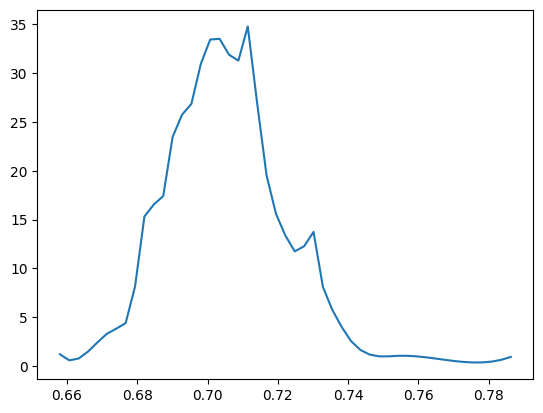

0.7058298472410983
Embedding Answers
99.047619047619054

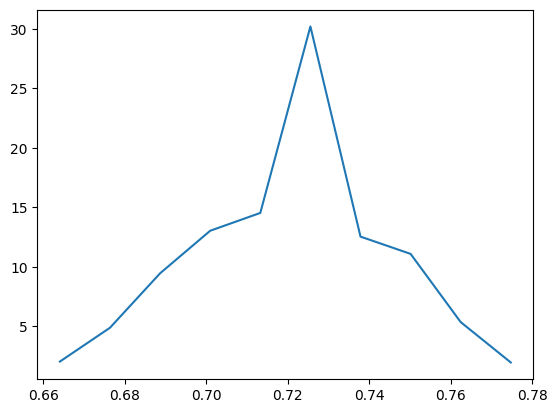

0.7207423172026928


In [60]:
#LitQA2 controlled answers
answer_store_control=[]
gen_control=[]
print("Embedding Questions")
for i in range(len(answer)):
    print(i/len(answer)*100, end="")
    print("\r", end="")
    if not ("No information" in answer[i]):
        store=embedding_questions(question[i], answer_control[i], "gpt-4o-mini")
        for score in store:
            gen_control.append(score)
gen_score=np.sum(np.array(gen_control))/float(len(gen_control))
n = len(gen_control)//10
s=np.array(gen_control)
p, x = np.histogram(s, bins=n) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=n)
plt.plot(x, f(x))
plt.show()
print(gen_score)
print("Embedding Answers")
for i in range(len(answer)):
    print(i/len(answer)*100, end="")
    print("\r", end="")
    answer_store_control.append(embedding_answers(answer_control[i], ideal[i]))
answer_score=np.sum(np.array(answer_store_control))/float(len(answer_store_control))
n = len(answer_store_control)//10
s=np.array(answer_store_control)
p, x = np.histogram(s, bins=n) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=n)
plt.plot(x, f(x))
plt.show()
print(answer_score)

Embedding Questions


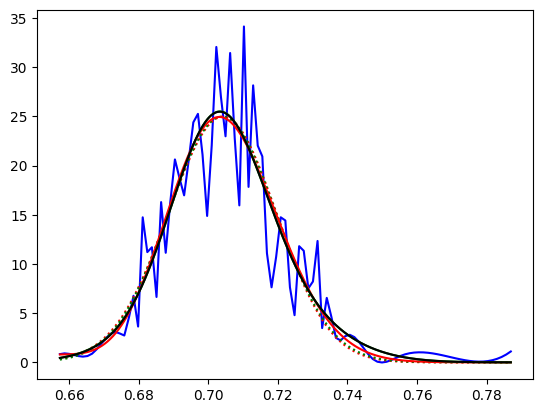

Beta log-likelihood: -63.3095867295454
Normal log-likelihood: -38.54616020644213
2Beta log-likelihood: -1087.2562819276427
2Normal log-likelihood: -209.98879377209266
Combined log-likelihood: -198.9954479360642
Normal distribution mean: 0.7039756367193749+/-0.015556976238492582
Beta distribution mean: 0.7037246859018222+/-0.015529623014627373
Normal distribution mean1: 0.7077010222404172+/-0.02017520418658676 Normal distribution mean2: 0.7023324453865412+/-0.01263299190272638
Beta distribution mean1: 0.6815408776513688+/-0.015174545316176976 Beta distribution mean2: 0.6941482057555456+/-0.019770723169112478
Combined distribution normal mean: 0.7022803834576703+/-0.01294583545201633 Combined distribution beta mean: 0.7085663027812074+/-0.020703023237122
Embedding Answers


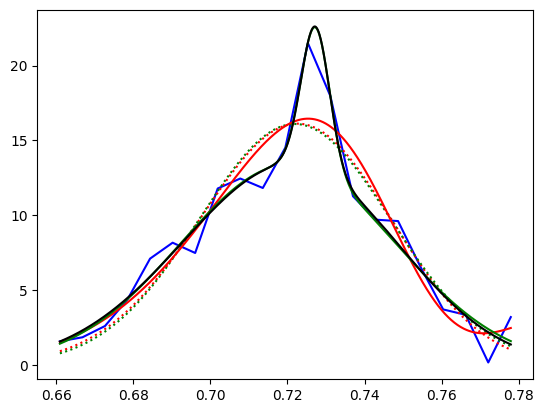

Beta log-likelihood: 37.18457329278432
Normal log-likelihood: 37.189739533797244
2Beta log-likelihood: -192.45711141942493
2Normal log-likelihood: -143.06776438749284
Combined log-likelihood: -144.21707040189696
Normal distribution mean: 0.7219298516782147+/-0.024813223792384844
Beta distribution mean: 0.7211966578092297+/-0.024719066521693634
Normal distribution mean1: 0.7202003132560836+/-0.0280425249225719 Normal distribution mean2: 0.7272420117620503+/-0.0037268194742502057
Beta distribution mean1: 0.7381589248817059+/-0.0327928592756965 Beta distribution mean2: 0.7583630260818067+/-0.01835194455680467
Combined distribution normal mean: 0.7272240021165775+/-0.003648113706430189 Combined distribution beta mean: 0.7193800038652115+/-0.027870003204364956


In [66]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as optimize
import scipy.integrate as integrate

def scaled_normal(x, scale, mu, sigma):
    return scale * stats.norm.pdf(x, loc=mu, scale=sigma)
def scaled_beta(x, a, b, scale):
    return scale*stats.beta.pdf(x, a, b, scale=1.0)
def scaled_2normal(x, scale1, scale2, mu1, mu2, sigma1, sigma2):
    return scale1 * stats.norm.pdf(x, loc=mu1, scale=sigma1)+scale2 * stats.norm.pdf(x, loc=mu2, scale=sigma2)
def scaled_2beta(x, a, b, c, d, scale1, scale2):
    return scale1*stats.beta.pdf(x, a, b, scale=1.0)+scale2*stats.beta.pdf(x, c, d, scale=1.0)
def scaled_norm_beta(x, scale_norm, mu, sigma, a, b, scale_beta):
    return scale_norm * stats.norm.pdf(x, loc=mu, scale=sigma)+scale_beta*stats.beta.pdf(x, a, b, scale=1.0)
    
def scaled_normal_log(x, scale, mu, sigma):
    filtered_norm=np.where(scaled_normal(x, scale, mu, sigma)>0.00001, scaled_normal(x, scale, mu, sigma), 0.00001)
    return np.sum(np.log(filtered_norm))
def scaled_beta_log(x, a, b, scale):
    filtered_beta=np.where(scaled_beta(x, a, b, scale)>0.00001, scaled_beta(x, a, b, scale), 0.00001)
    return np.sum(np.log(filtered_beta))
def scaled_2normal_log(x, scale1, scale2, mu1, mu2, sigma1, sigma2):
    store1=scale1 * stats.norm.pdf(x, loc=mu1, scale=sigma1)
    store2=scale2 * stats.norm.pdf(x, loc=mu2, scale=sigma2)
    store1=np.where(store1>0.00001, store1, 0.00001)
    store2=np.where(store2>0.00001, store2, 0.00001)
    store=np.log(store1)+np.log(store2)
    return np.sum(store)
def scaled_2beta_log(x, a, b, c, d, scale1, scale2):
    store1=scale1*stats.beta.pdf(x, a, b, scale=1.0)
    store2=scale2*stats.beta.pdf(x, c, d, scale=1.0)
    store1=np.where(store1>0.00001, store1, 0.00001)
    store2=np.where(store2>0.00001, store2, 0.00001)
    store=np.log(store1)+np.log(store2)
    return np.sum(store)
def scaled_norm_beta_log(x, scale_norm, mu, sigma, a, b, scale_beta):
    store1=scale_norm * stats.norm.pdf(x, loc=mu, scale=sigma)
    store2=scale_beta*stats.beta.pdf(x, a, b, scale=1.0)
    store1=np.where(store1>0.00001, store1, 0.00001)
    store2=np.where(store2>0.00001, store2, 0.00001)
    store=np.log(store1)+np.log(store2)
    return np.sum(store)

def stats_print_graphs(n, s):
    p, x = np.histogram(s, bins=n, density=True) # bin it into n = N//10 bins
    x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
    func = UnivariateSpline(x, p, s=n)
    try:
        popt, pcov_beta = optimize.curve_fit(scaled_beta, x, func(x), p0=[2.0, 2.0, 1.0])
        alpha, beta, scale_beta = popt
    except:
        alpha=1.0
        beta=1.0
        scale_beta=0.0001
    try:
        popt, pcov_norm = optimize.curve_fit(scaled_normal, x, func(x), p0=[1.0, 0.7, 0.1])
        scale_norm, mu, sigma = popt
    except:
        scale_norm=0.0001
        mu=0.5
        sigma=0.1
    try:
        popt, pcov_beta = optimize.curve_fit(scaled_2beta, x, func(x), p0=[2.0, 2.0, 2.0, 2.0, 0.5, 0.5])
        a, b, c, d, scale_beta1, scale_beta2 = popt
    except:
        a=1.0
        b=1.0
        c=1.0
        d=1.0
        scale_beta1=0.0001
        scale_beta2=0.0001
    try:
        popt, pcov_norm = optimize.curve_fit(scaled_2normal, x, func(x), p0=[0.5, 0.5, 0.7, 0.7, 0.1, 0.1])
        scale_norm1, scale_norm2, mu1, mu2, sigma1, sigma2 = popt
    except:
        scale_norm1=0.0001
        scale_norm2=0.0001
        mu1=0.5
        mu2=0.5
        sigma1=0.1
        sigma2=0.1
    try:
        popt, pcov_norm = optimize.curve_fit(scaled_norm_beta, x, func(x), p0=[0.5, 0.7, 0.1, 2.0, 2.0, 0.5])
        scale_norm3, mu3, sigma3, e, f, scale_beta3 = popt
    except:
        scale_norm3=0.0001
        mu3=0.5
        sigma3=0.1
        e=1.0
        f=1.0
        scale_beta3=0.0001
    min_x=np.amin(x)
    max_x=np.amax(x)
    x_plot=np.linspace(np.amin(x), np.amax(x), 1000)
    plt.plot(x, func(x), "b-")
    plt.plot(x_plot, scaled_beta(x_plot, alpha, beta, scale_beta), "r:")
    plt.plot(x_plot, scaled_normal(x_plot, scale_norm, mu, sigma), "g:")
    plt.plot(x_plot, scaled_2beta(x_plot, a, b, c, d, scale_beta1, scale_beta2), "r-")
    plt.plot(x_plot, scaled_2normal(x_plot, scale_norm1, scale_norm2, mu1, mu2, sigma1, sigma2), "g-")
    plt.plot(x_plot, scaled_norm_beta(x_plot, scale_norm3, mu3, sigma3, e, f, scale_beta3), "k-")
    plt.show()
    beta_normalisation=integrate.quad(lambda x: scaled_beta(x, alpha, beta, scale_beta), min_x, max_x)

    norm_normalisation=integrate.quad(lambda x: scaled_normal(x, scale_norm, mu, sigma), min_x, max_x)

    beta2_normalisation=integrate.quad(lambda x: scaled_2beta(x, a, b, c, d, scale_beta1, scale_beta2), min_x, max_x)

    norm2_normalisation=integrate.quad(lambda x: scaled_2normal(x, scale_norm1, scale_norm2, mu1, mu2, sigma1, sigma2), min_x, max_x)

    norm_beta_normalisation=integrate.quad(lambda x: scaled_norm_beta(x, scale_norm3, mu3, sigma3, e, f, scale_beta3), min_x, max_x)

    print("Beta log-likelihood: "+str(scaled_beta_log(x, alpha, beta, scale_beta)-n*np.log(beta_normalisation[0])))
    print("Normal log-likelihood: "+str(scaled_normal_log(x, scale_norm, mu, sigma)-n*np.log(norm_normalisation[0])))
    print("2Beta log-likelihood: "+str(scaled_2beta_log(x, a, b, c, d, scale_beta1, scale_beta2)-n*np.log(beta2_normalisation[0])))
    print("2Normal log-likelihood: "+str(scaled_2normal_log(x, scale_norm1, scale_norm2, mu1, mu2, sigma1, sigma2)-n*np.log(norm2_normalisation[0])))
    print("Combined log-likelihood: "+str(scaled_norm_beta_log(x, scale_norm3, mu3, sigma3, e, f, scale_beta3)-n*np.log(norm_beta_normalisation[0])))
    print("Normal distribution mean: "+str(mu)+"+/-"+str(sigma))
    print("Beta distribution mean: "+str(stats.beta.mean(alpha, beta, scale=1.0))+"+/-"+str(stats.beta.std(alpha, beta, scale=1.0)))
    print("Normal distribution mean1: "+str(mu1)+"+/-"+str(sigma1)+" Normal distribution mean2: "+str(mu2)+"+/-"+str(sigma2))
    print("Beta distribution mean1: "+str(stats.beta.mean(a, b, scale=1.0))+"+/-"+str(stats.beta.std(a, b, scale=1.0))+" Beta distribution mean2: "+str(stats.beta.mean(c, d, scale=1.0))+"+/-"+str(stats.beta.std(c, d, scale=1.0)))
    print("Combined distribution normal mean: "+str(mu3)+"+/-"+str(sigma3)+" Combined distribution beta mean: "+str(stats.beta.mean(e, f, scale=1.0))+"+/-"+str(stats.beta.std(e, f, scale=1.0)))

n = len(gen_control)//5
s=np.array(gen_control)
print("Embedding Questions")
stats_print_graphs(n, s)

n = len(answer_store_control)//5
s=np.array(answer_store_control)
print("Embedding Answers")
stats_print_graphs(n, s)